In [2]:
import cv2
import os,json
import natsort
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers

C:\Users\VARUN PN\AppData\Local\Temp\ipykernel_632\3531047777.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
path="./myData"
labelFile="./labels/labels.csv"
batch_size_val=50
steps_per_epoch_val=2000
epochs_val=10
imageDimensions=(32,32,3)
testRatio=0.2
validationRatio=0.2

In [4]:
count=0
images=[]
classNo=[]
folderList=os.listdir(path)
noOfClasses=len(folderList)

print("Total Classes Detected : ",noOfClasses)

for cls in folderList:
    imgFlderpath=os.path.join(path,cls)
    
    for img in os.listdir(imgFlderpath):
        image_path=os.path.join(imgFlderpath,img)
        image=cv2.imread(image_path)
        images.append(image)
        classNo.append(count)
        
    print(count,end=" ")
    count+=1

images=np.array(images)
classNo=np.array(classNo)

### Split Data

X_train,X_test,y_train,y_test=train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation=train_test_split(X_train,y_train,test_size=validationRatio)     

Total Classes Detected :  43
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

In [5]:
assert(X_train.shape[0]==y_train.shape[0])
assert(X_validation.shape[0]==y_validation.shape[0])
assert(X_test.shape[0]==y_test.shape[0])

In [6]:
assert(X_train.shape[1:]==(imageDimensions))
assert(X_validation.shape[1:]==(imageDimensions))
assert(X_test.shape[1:]==(imageDimensions))

In [7]:
label_id_name={}

with open("./labels/labels.csv") as f:
    csv_data=csv.DictReader(f)

    for csv_ in csv_data:
        class_id=csv_["ClassId"]
        className=csv_["Name"]
        label_id_name[class_id]=className

print(label_id_name)

{'0': 'Speed limit (20km/h)', '1': 'Speed limit (30km/h)', '2': 'Speed limit (50km/h)', '3': 'Speed limit (60km/h)', '4': 'Speed limit (70km/h)', '5': 'Speed limit (80km/h)', '6': 'End of speed limit (80km/h)', '7': 'Speed limit (100km/h)', '8': 'Speed limit (120km/h)', '9': 'No passing', '10': 'No passing for vechiles over 3.5 metric tons', '11': 'Right-of-way at the next intersection', '12': 'Priority road', '13': 'Yield', '14': 'Stop', '15': 'No vechiles', '16': 'Vechiles over 3.5 metric tons prohibited', '17': 'No entry', '18': 'General caution', '19': 'Dangerous curve to the left', '20': 'Dangerous curve to the right', '21': 'Double curve', '22': 'Bumpy road', '23': 'Slippery road', '24': 'Road narrows on the right', '25': 'Road work', '26': 'Traffic signals', '27': 'Pedestrians', '28': 'Children crossing', '29': 'Bicycles crossing', '30': 'Beware of ice/snow', '31': 'Wild animals crossing', '32': 'End of all speed and passing limits', '33': 'Turn right ahead', '34': 'Turn left ah

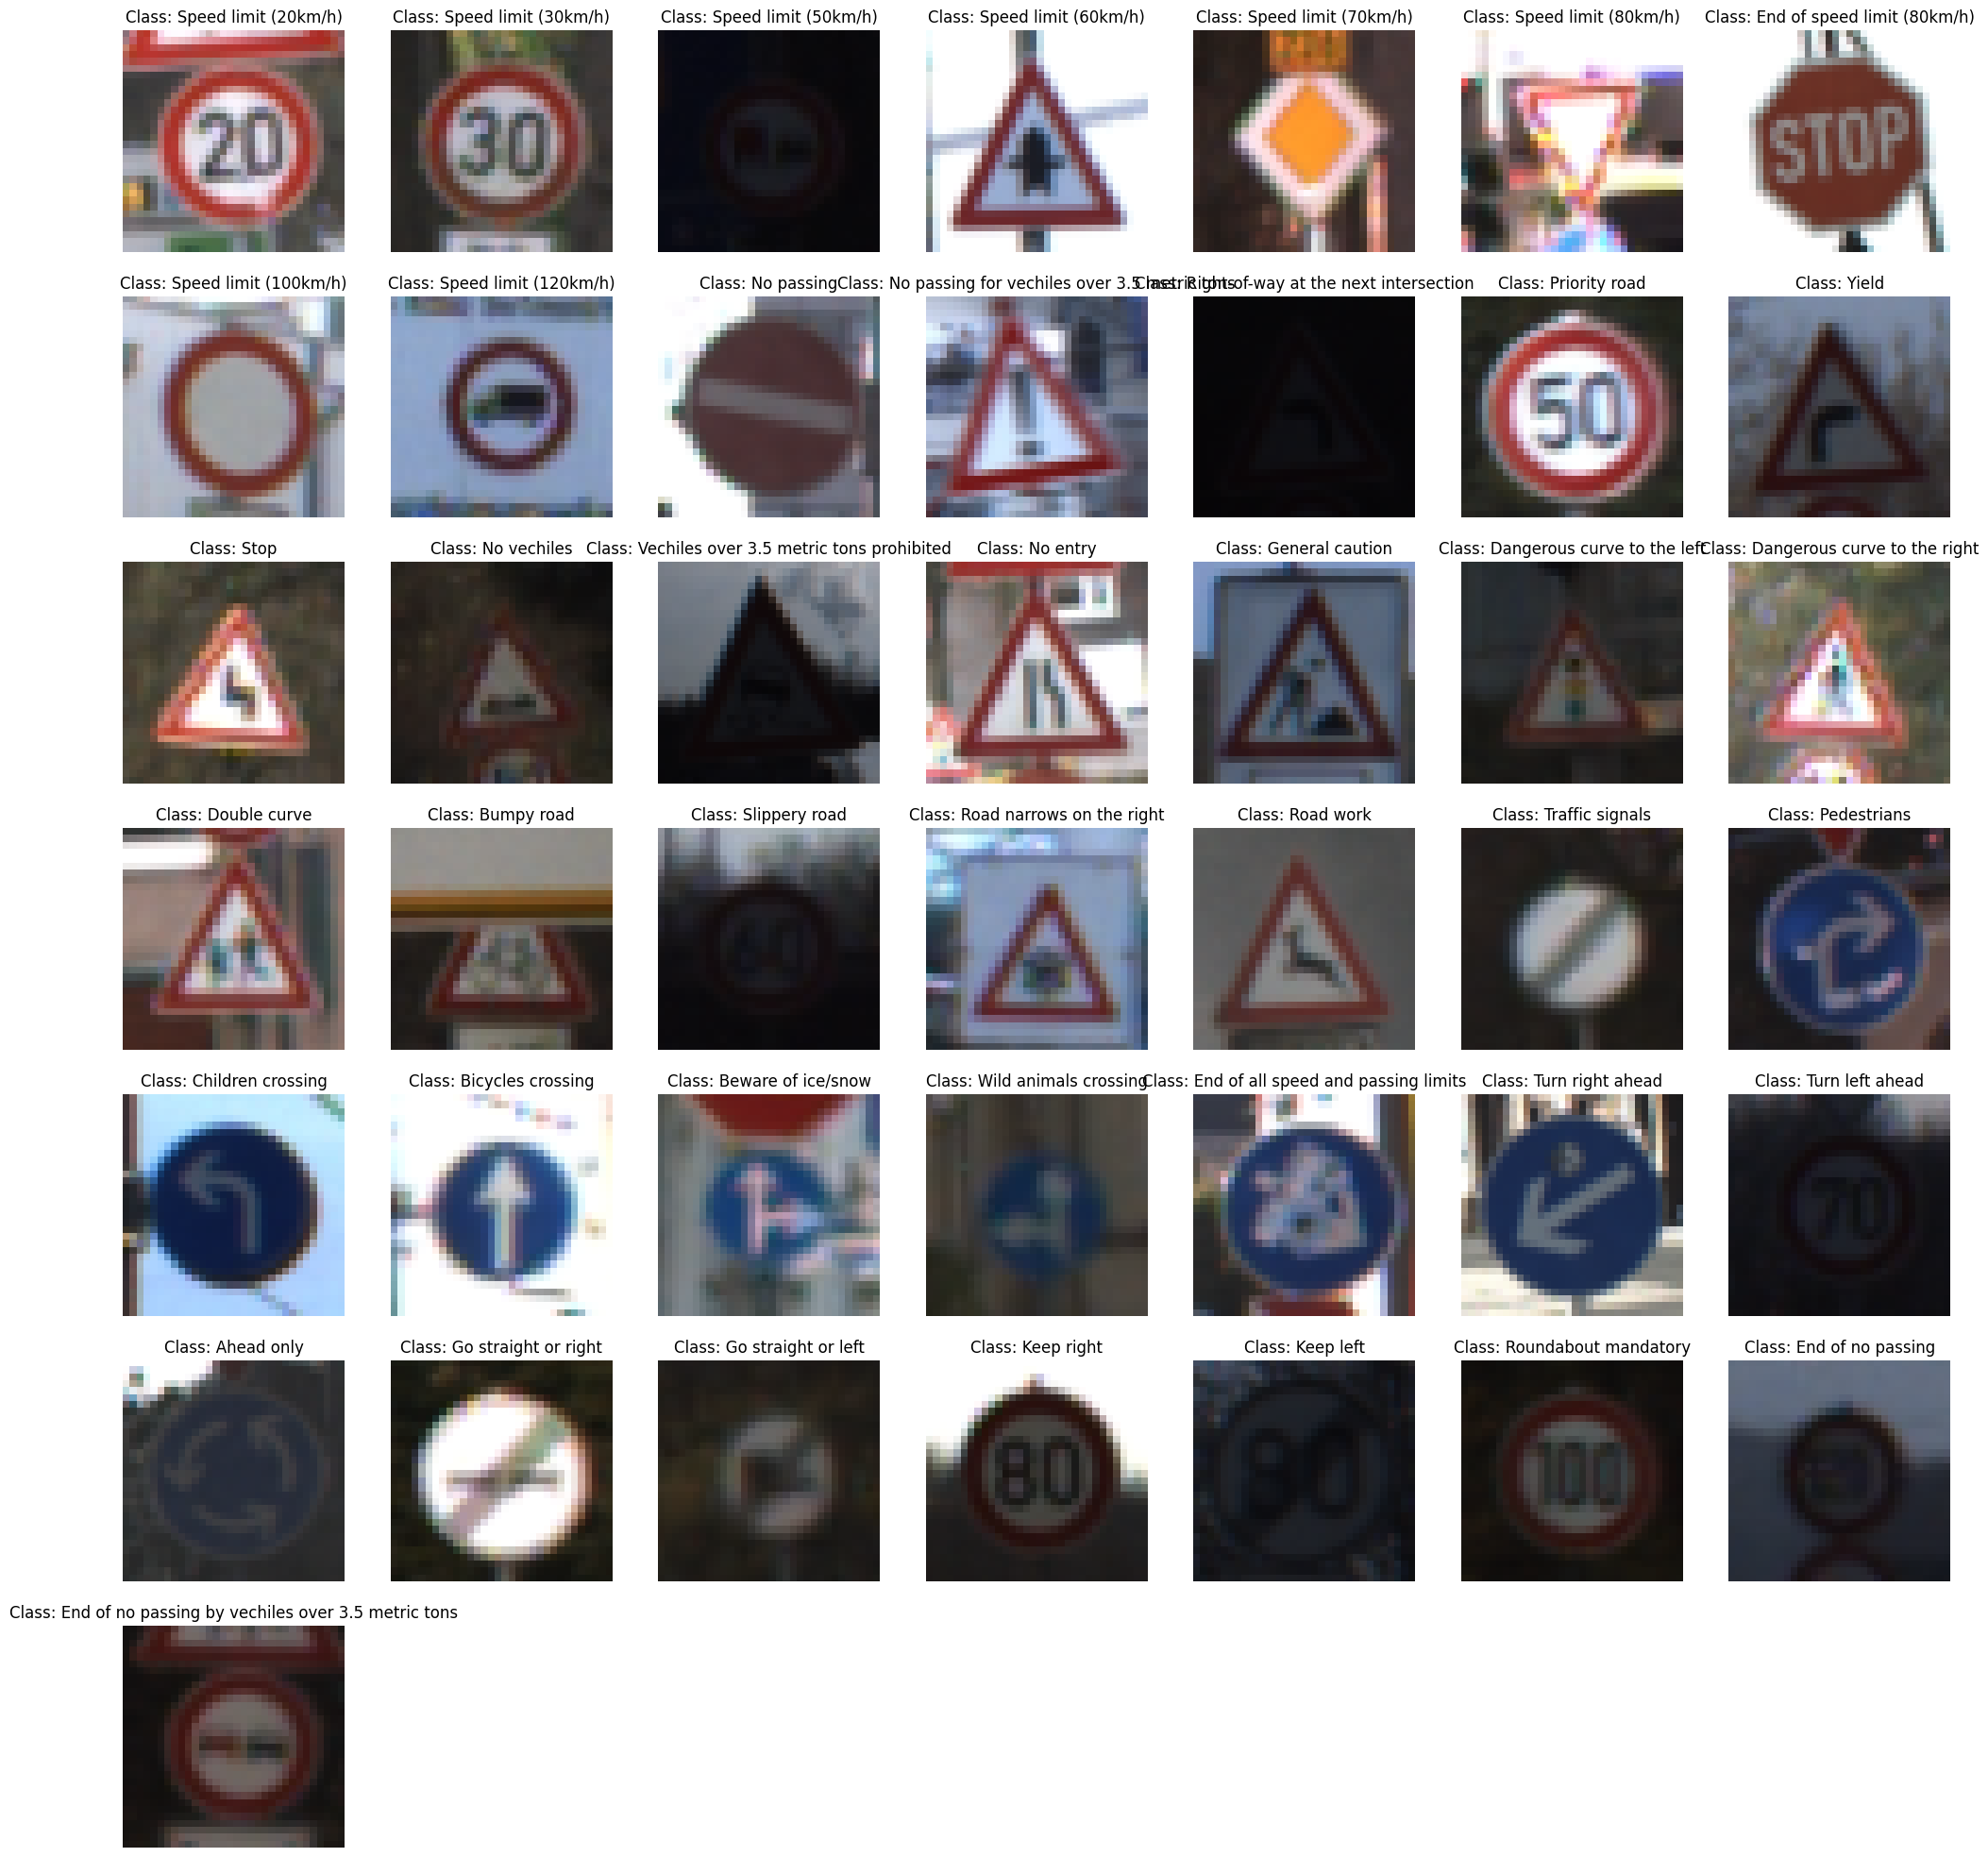

In [8]:
import matplotlib.pyplot as plt

# Function to plot one sample from each class
def plot_samples(X_data, y_data, num_classes):
    fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(25, 25))
    
    for i, ax in enumerate(axes.flat):
        class_found=False
        
        for j in range(len(y_data)):
            
            if y_data[j] == i:
                ax.imshow(X_data[j])
                ax.set_title(f"Class: {label_id_name[str(y_data[j])]}")
                ax.axis('off')
                class_found=True
                break
                
# ============If no sample found for this class, remove the subplot==================                
        if not class_found:
            fig.delaxes(ax)
            
    # plt.tight_layout()
    plt.show()

# Call the function to plot one sample from each class
plot_samples(X_train, y_train, noOfClasses)
 

In [9]:
dataset_path="./myData"
class_img_count={}

for folder in natsort.natsorted(os.listdir(dataset_path)):
    folderpath=os.path.join(dataset_path,folder)
    class_img_count[folder]=len(os.listdir(folderpath))


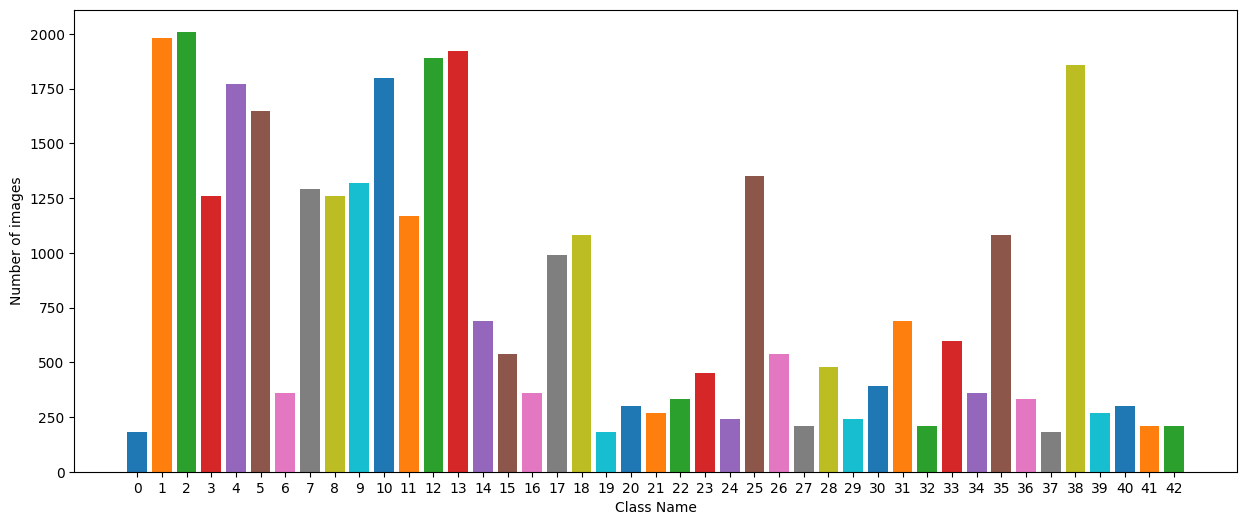

In [10]:
plt.figure(figsize=(15, 6))
plt.xlabel("Class Name")
plt.ylabel("Number of images")
for clsname,imgcnt in class_img_count.items():
    plt.bar(clsname, imgcnt)
    

In [11]:
##========== Preprocess The image ===========

In [12]:
def preprocess(img):
    imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgEqualize=cv2.equalizeHist(imgGray)
    imgScale=imgEqualize/255

    return imgScale

In [13]:
X_train=np.array(list(map(preprocess,X_train)))
X_test=np.array(list(map(preprocess,X_test)))
X_validation=np.array(list(map(preprocess,X_validation)))

In [14]:
#Adding Depth of 1
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)

In [15]:
## Augmentation of images : To make it more generic

In [16]:
dataGen=ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)

In [17]:
dataGen.fit(X_train)

In [18]:

# REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
batches=dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch=next(batches)

In [19]:
y_train=to_categorical(y_train,noOfClasses)
y_test=to_categorical(y_test,noOfClasses)
y_validation=to_categorical(y_validation,noOfClasses)

In [20]:
# CNN implementation

In [21]:
model=models.Sequential([
    layers.Conv2D(60,(5,5),input_shape=(imageDimensions[0],imageDimensions[1],1),activation="relu"),
    layers.Conv2D(60,(5,5),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(30,(3,3),activation="relu"),
    layers.Conv2D(30,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),   
    layers.Dropout(0,5),
    layers.Flatten(),
    layers.Dense(500,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(noOfClasses,activation="relu"),
    layers.Dropout(0.5)
    
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                   

In [24]:
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=batch_size_val),
    steps_per_epoch=len(X_train) // batch_size_val,
    epochs=epochs_val,
    validation_data=(X_validation, y_validation),
    shuffle=True
)

Epoch 1/10
445/445 [==============================] - 99s 222ms/step - loss: 10.4863 - accuracy: 0.0579 - val_loss: 5.3219 - val_accuracy: 0.0587
Epoch 2/10
445/445 [==============================] - 100s 225ms/step - loss: 10.4879 - accuracy: 0.0721 - val_loss: 5.0520 - val_accuracy: 0.1911
Epoch 3/10
445/445 [==============================] - 94s 212ms/step - loss: nan - accuracy: 0.0779 - val_loss: 8.4865 - val_accuracy: 0.0550
Epoch 4/10
445/445 [==============================] - 96s 216ms/step - loss: nan - accuracy: 0.0549 - val_loss: 8.4845 - val_accuracy: 0.0526
Epoch 5/10
445/445 [==============================] - 97s 218ms/step - loss: nan - accuracy: 0.0556 - val_loss: 8.4815 - val_accuracy: 0.0546
Epoch 6/10
445/445 [==============================] - 96s 215ms/step - loss: nan - accuracy: 0.0576 - val_loss: 8.4834 - val_accuracy: 0.0510
Epoch 7/10
445/445 [==============================] - 95s 213ms/step - loss: nan - accuracy: 0.0521 - val_loss: 8.4817 - val_accuracy: 0.05

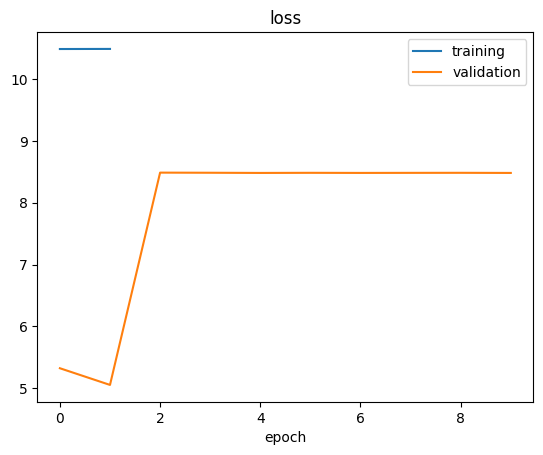

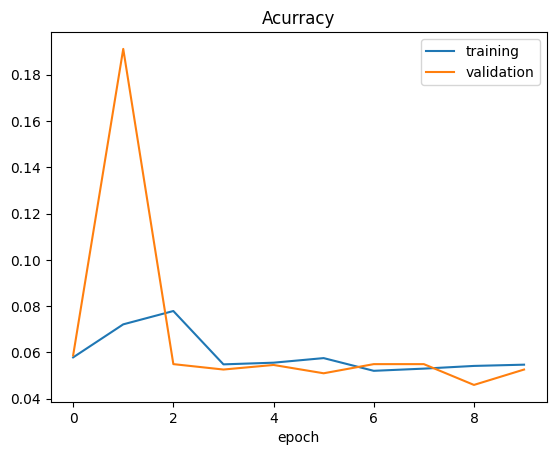

In [25]:
############################### PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()